In [1]:
from IPython.display import display, clear_output, HTML
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
from timeit import default_timer as timer
from os import path

%matplotlib inline


###   HELP FUNCTIONS   ###
def node_distance(Graph, n1, n2):
    """Calculate the distance between nodes n1 and n2 in a Graph"""
    a = Graph.nodes[n1]["pos"]
    b = Graph.nodes[n2]["pos"]
    return np.linalg.norm(a - b)


def node_pos_dict(Graph):
    """Make a dictionary {node: [x_coordinate, y_coordinate]}."""
    return {k: v.tolist() for k, v in G.nodes.data("pos")}


def get_length(Graph):
    """Calculate the total length of the graph """
    return sum([d for (n1, n2, d) in Graph.edges.data("distance")])


def get_rnd_graph(N):
    """ Generate a random graph with N nodes"""
    G = nx.Graph()
    G.add_nodes_from([(n, {"pos": np.random.rand(2)}) for n in range(N)])
    G.add_edges_from(
        [
            (n, (n + 1) % N, {"distance": node_distance(G, n, (n + 1) % N)})
            for n in range(N)
        ]
    )
    G.graph["length"] = get_length(G)
    G.graph["N"] = N
    return G


def remove_waypoint(Graph, n):
    """Remove node n from its neighbours, and connect the dangling neighbours"""
    n1, n2 = list(Graph.neighbors(n))
    n1_to_n2, n_to_n1, n_to_n2 = (
        node_distance(Graph, n1, n2),
        node_distance(Graph, n, n1),
        node_distance(Graph, n, n2),
    )
    Graph.add_edge(n1, n2, distance=n1_to_n2)
    Graph.remove_edge(n, n1)
    Graph.remove_edge(n, n2)
    Graph.graph["length"] += n1_to_n2 - n_to_n1 - n_to_n2


def add_waypoint(Graph, n, n1, n2):
    """Add node n between nodes n1 and n2"""
    n1_to_n2, n_to_n1, n_to_n2 = (
        node_distance(Graph, n1, n2),
        node_distance(Graph, n, n1),
        node_distance(Graph, n, n2),
    )
    Graph.graph["length"] += n_to_n1 + n_to_n2 - n1_to_n2
    Graph.remove_edge(n1, n2)
    Graph.add_edge(n1, n, distance=n_to_n1)
    Graph.add_edge(n, n2, distance=n_to_n2)


def move_waypoint(Graph, n, n1, n2):
    """Move waypoint n between n1 and n2"""
    remove_waypoint(Graph, n)
    add_waypoint(Graph, n, n1, n2)


def get_rnd_move(Graph):
    """Pick a random node n to be moved between n1 and n2"""
    n, n1 = np.random.randint(low=0, high=Graph.graph["N"], size=2)
    while (
        n1 in list(Graph.neighbors(n)) or n == n1
    ):  # Try again if n and n1 are already nbrs
        n, n1 = np.random.randint(low=0, high=Graph.graph["N"], size=2)
    n2 = random.choice(list(Graph.neighbors(n1)))
    return (n, n1, n2)


def diff_E(Graph, n, n1, n2):
    """Calculate the energy of moving node n between nodes n1 and n2"""
    nbr1, nbr2 = list(Graph.neighbors(n))
    nbr1_to_nbr2, n_to_nbr1, n_to_nbr2 = (
        node_distance(Graph, nbr1, nbr2),
        node_distance(Graph, n, nbr1),
        node_distance(Graph, n, nbr2),
    )

    n1_to_n2, n_to_n1, n_to_n2 = (
        node_distance(Graph, n1, n2),
        node_distance(Graph, n, n1),
        node_distance(Graph, n, n2),
    )

    return nbr1_to_nbr2 - n_to_nbr1 - n_to_nbr2 + n_to_n1 + n_to_n2 - n1_to_n2


def plot_progress(fig, ax1, ax2, Graph, temp, Tmin, Tmax, cmap=plt.cm.plasma):
    ax1.cla()
    ax1.set_title(
        "T = %.f, Length = %.2f" % (temp[-1], G.graph["length"])
    )
    nx.draw(
        G,
        pos=node_pos_dict(G),
        with_labels=False,
        node_size=100,
        ax=ax1,
        node_color=[temp[-1]] * G.graph["N"],
        cmap=cmap,
        vmin=Tmin,
        vmax=Tmax,
        edge_color=[temp[-1]] * G.graph["N"],
        edge_cmap=cmap,
        edge_vmin=Tmin,
        edge_vmax=Tmax,
    )

    ax2.cla()
    ax2.set(xlim=(Tmax, Tmin - 1), ylabel="Length [m]", xlabel="Temperature [K]")
    ax2.tick_params(
        axis="both",
        which="both",
        bottom=True,
        labelbottom=True,
        left=True,
        labelleft=True,
    )
    ax2.scatter(track_t, track_l, cmap=cmap, c=track_t, vmin=Tmin, vmax=Tmax)
    display(fig)
    clear_output(wait=True)


# Path finding via random points

Annealing took 4.89 seconds


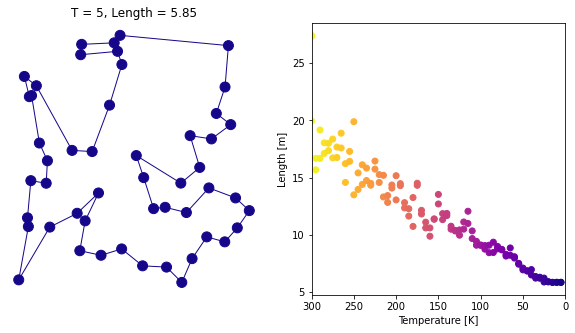

In [2]:
### PARAMETERS ###
random.seed(22)
np.random.seed(77)
N_nodes = 50
Tmax = 300
Tmin = 1
cooling_rate = -5 # Negative int
N_walks = 1000
plot_walk = False # Very slow (e.g. 20 seconds to .3 seconds)


### INITIALIZATION ###
G = get_rnd_graph(N=N_nodes)
#  k_b is "Available error per Kelvin",  avg_initial_error / T_max is a good estimate:
k_b = G.graph["length"] / N_nodes / 2 / Tmax


### ANNEALING ###
track_t, track_l = [], [] 
track_t.append(Tmax)
track_l.append(G.graph["length"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_progress(fig, ax1, ax2, G, track_t, Tmin, Tmax)

start = timer()
for temp in np.arange(Tmax, Tmin, cooling_rate):
    for walk in range(N_walks):
        # Move
        (n, n1, n2) = get_rnd_move(G)
        if random.random() < np.exp(-1 * diff_E(G, n, n1, n2) / (k_b * temp)):
            move_waypoint(G, n, n1, n2)

        # Track
        if walk % (N_walks / 2) == 0:
            track_t.append(temp)
            track_l.append(G.graph["length"])
            if plot_walk:
                plot_progress(fig, ax1, ax2, G, track_t, Tmin, Tmax)
end = timer()


plot_progress(fig, ax1, ax2, G, track_t, Tmin, Tmax)

print("Annealing took %.2f seconds" % (end - start))

In [3]:
fig.savefig(path.join('.', 'media', 'convergence_demo.png'))

# The same, but as an animation

In [4]:
### PARAMETERS ###
random.seed(22)
np.random.seed(77)
N_nodes = 50
Tmax = 300
Tmin = 1
cooling_rate = -3 # Negative int
N_walks = 1000
walks_per_frame = N_walks


### INITIALIZATION ###
G = get_rnd_graph(N=N_nodes)
#  k_b is "Available error per Kelvin",  avg_initial_error / T_max is a good estimate:
k_b = G.graph["length"] / N_nodes / 2 / Tmax


def update(i):
    ### ANNEALING ###
    temp = Tmax + i * cooling_rate
    for walk in range(walks_per_frame):
        # move
        (n, n1, n2) = get_rnd_move(G)
        if random.random() < np.exp(-1 * diff_E(G, n, n1, n2) / (k_b * temp)):
            move_waypoint(G, n, n1, n2)
    
    ### PLOTTING ###
    ax1.cla()
    ax1.set_title("T = %.f, Length = %.2f" % (temp, G.graph["length"]))
    nx.draw(
        G,
        pos=node_pos_dict(G),
        with_labels=False,
        node_size=100,
        ax=ax1,
        node_color=[temp] * G.graph["N"],
        cmap=plt.cm.plasma,
        vmin=Tmin,
        vmax=Tmax,
        edge_color=[temp] * G.graph["N"],
        edge_cmap=plt.cm.plasma,
        edge_vmin=Tmin,
        edge_vmax=Tmax,
    )
    display(fig)
    clear_output(wait=True)

fig, ax1 = plt.subplots()
rc("animation", html="jshtml")  # HTML(anim.to_jshtml()) by default
anim = animation.FuncAnimation(
    fig, update, frames=int(-1 * (Tmax - Tmin) / cooling_rate), interval=100
)
display(anim)
plt.close(fig)

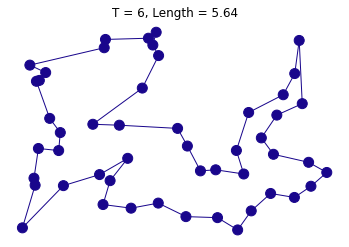

In [5]:
random.seed(22)
np.random.seed(77)
G = get_rnd_graph(N=N_nodes)

# Store as gif
writergif = animation.PillowWriter(fps=10) 
anim.save(path.join('.', 'media', 'annealing_demo.gif'), writer=writergif)

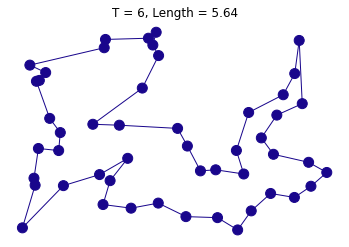

In [6]:
random.seed(22)
np.random.seed(77)
G = get_rnd_graph(N=N_nodes)

# Store as mp4. Usefull tutorials
# https://www.wikihow.com/Install-FFmpeg-on-Windows
# https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'
writervideo = animation.FFMpegWriter(fps=10) 
anim.save(path.join('.', 'media', 'annealing_demo.mp4'), writer=writervideo)